# Constructing Morphological Networks from Overture Maps

In this notebook, we'll walk through the following workflow:

1. **Data Preparation**: Loading and processing street segments and building data from Overture Maps
2. **Space Division**: Creating morphological tessellations to represent private spaces
3. **Network Creation**: Generating different types of morphological networks:
   - Private-to-private connections (between adjacent private spaces)
   - Public-to-public connections (between street segments)
   - Private-to-public connections (between private spaces and streets)
4. **Graph Conversion**: Converting spatial networks to graph representations using PyTorch Geometric
5. **Visualization**: Exploring different ways to visualize the morphological networks

These graph representations enable various analyses of urban form, including connectivity studies, accessibility measures, and graph-based machine learning for urban analytics.

## 1. Setup and Environment

In [1]:
import numpy as np
from shapely import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import city2graph

# Configure matplotlib for better visualizations
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

## 2. Data Loading and Preparation

We'll work with data from Liverpool, UK, including building footprints and road network segments. These data are stored as GeoJSON files. `area` accepts either bbox or Polygon in WGS84.

In [2]:
"""
bbox = [-3.090173,53.355487,-2.917138,53.465587] # Liverpool city centre
city2graph.load_overture_data(area=bbox,
                              types=["segment", "building", "connector"],
                              output_dir=".",
                              prefix="liverpool_",
                              save_to_file=True,
                              return_data=False)
"""

'\nbbox = [-3.090173,53.355487,-2.917138,53.465587] # Liverpool city centre\ncity2graph.load_overture_data(area=bbox,\n                              types=["segment", "building", "connector"],\n                              output_dir=".",\n                              prefix="liverpool_",\n                              save_to_file=True,\n                              return_data=False)\n'

In [3]:
# Load GeoJSON files
buildings_gdf = gpd.read_file("liverpool_building.geojson")
segments_gdf = gpd.read_file("liverpool_segment.geojson")
connectors_gdf = gpd.read_file("liverpool_connector.geojson")

# Convert to British National Grid (EPSG:27700)
buildings_gdf = buildings_gdf.to_crs(epsg=27700)
segments_gdf = segments_gdf.to_crs(epsg=27700)
connectors_gdf = connectors_gdf.to_crs(epsg=27700)

print(f"Loaded {len(buildings_gdf)} buildings, {len(segments_gdf)} segments, and {len(connectors_gdf)} connectors")

Loaded 132972 buildings, 37474 segments, and 47367 connectors


## 3. Street Network Processing

`city2graph` offers functions that can process and clean up the original segments from Overture Maps. Eventually, `barrier_geometry` stores the ones not considered as tunnels and/or bridges.

In [4]:
# Filter road segments and process them to handle tunnels
segments_gdf = segments_gdf[segments_gdf["subtype"] == "road"].copy()

# Create barrier_geometry column by processing each segment (excluding tunnels)
segments_gdf = city2graph.process_overture_segments(segments_gdf=segments_gdf,
                                                    get_barriers=True,
                                                    connectors_gdf=connectors_gdf)

## 4. Create Morphological Network
Based on the preprocessed segments and buildings, **a morphological network** is created by the following process:

<div align="center">
    <img src="../_static/morph_net_process.png" alt="City2Graph Logo" width="1000"/>
</div>

Morphological network is a heterogenous graph where all the spaces in cities are holistically represented as nodes. 

In this representation, the topological connections between public and private spaces can be captured. Unlike street network and contiguity matrix of built environment, morphological network can accomodate any of the charactors for urban forms and functions, such as POIs, land-use, street types, and etc. It will be a foundation for spatially-explicit GeoAI by graph representation learning, keeping the characters as node attributes.

There are three types of connections as edges: public-to-public, private-to-private, and private-to-public. Public-to-public connections are dual representation of street networks. Private-to-private shows the contiguities between enclosed tessellations as plot systems. Private-to-public can identify the adjacency between public and private spaces.

`city2graph.morphological_graph` can process the creation of morphological network as a dictionary of `gpd.GeoDataFrame` consisting of `['tessellation', 'segments', 'buildings', 'private_to_private', 'public_to_public', 'private_to_public']`. Post-processing, such as mapping POIs to private spaces, can be done accordingly.

In [5]:
# Get all unique geometry types in the barrier_geometry column
geometry_types = segments_gdf["barrier_geometry"].geom_type.value_counts()
print("Geometry types in barrier_geometry column:")
print(geometry_types)

# Also show the total count
print(f"\nTotal geometries: {len(segments_gdf['barrier_geometry'])}")

# Check for any null values
null_count = segments_gdf["barrier_geometry"].isnull().sum()
print(f"Null values: {null_count}")

Geometry types in barrier_geometry column:
LineString         61455
MultiLineString      205
Name: count, dtype: int64

Total geometries: 62116
Null values: 456


In [6]:
center_point = gpd.GeoSeries([Point((-2.9879004, 53.4062724))], crs='EPSG:4326').to_crs(epsg=27700)

morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,
    clipping_buffer=300,
    primary_barrier_col='barrier_geometry',
    contiguity="queen",
    keep_buildings=True,
    )

/Users/yutasato/Projects/Liverpool/city2graph/city2graph/morphology.py:1208: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  return libpysal.weights.Queen.from_dataframe(gdf)
/Users/yutasato/Projects/Liverpool/city2graph/.venv/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


    private_id  public_id                                           geometry
4      1_93892      31472  LINESTRING (334727.903 390226.444, 334690.314 ...
4      1_93892      31471  LINESTRING (334727.903 390226.444, 334718.994 ...
4      1_93892      31688  LINESTRING (334727.903 390226.444, 334744.403 ...
572    6_73782      19445  LINESTRING (334110.181 390374.626, 334071.747 ...
572    6_73782      19475  LINESTRING (334110.181 390374.626, 334104.446 ...
..         ...        ...                                                ...
915     438_-3      32025  LINESTRING (334781.229 390671.103, 334779.901 ...
915     438_-3      31654  LINESTRING (334781.229 390671.103, 334762.418 ...
915     438_-3      32027  LINESTRING (334781.229 390671.103, 334785.147 ...
915     438_-3      32026  LINESTRING (334781.229 390671.103, 334779.2 39...
915     438_-3      32034  LINESTRING (334781.229 390671.103, 334785.843 ...

[2511 rows x 3 columns]


In [7]:
morpho_nodes.keys()

dict_keys(['private', 'public'])

In [8]:
morpho_edges.keys()

dict_keys([('private', 'touched_to', 'private'), ('public', 'connected_to', 'public'), ('private', 'faced_to', 'public')])

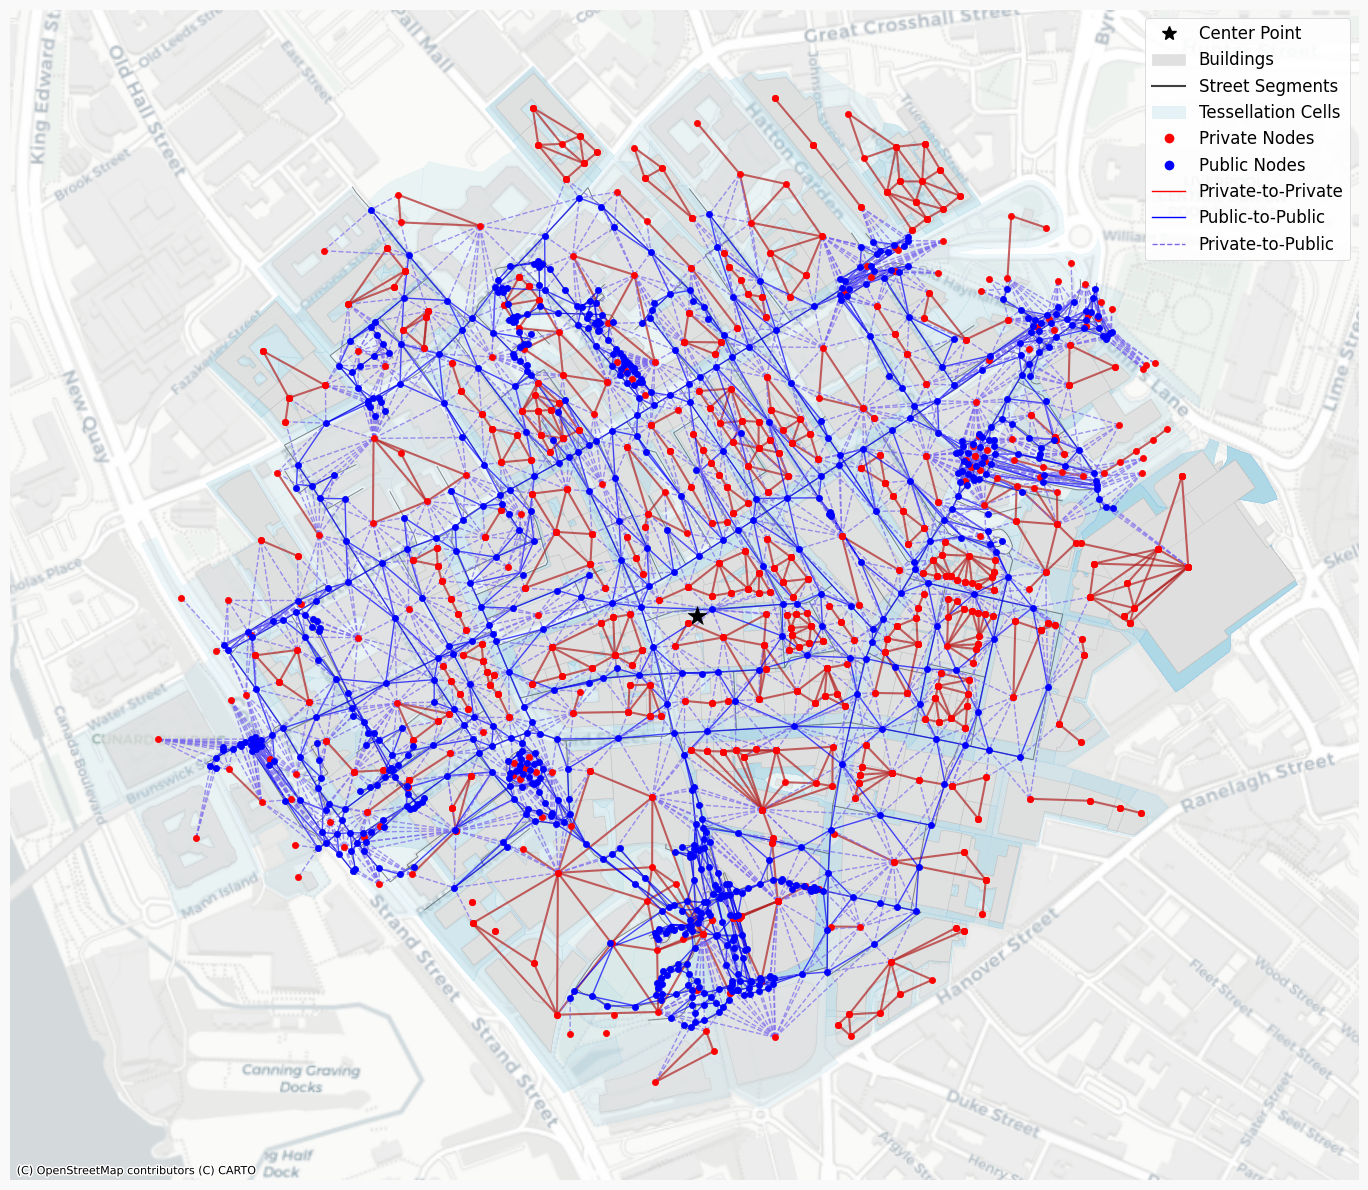

In [9]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"]["building_geometry"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right', 
          frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()

## 5. Convert to Graph Representations

Now we'll convert our morphological networks to graph representations using PyTorch Geometric for graph representation learning. As dependencies, `torch` and `torch_geometric` have to be installed in advance.

In [ ]:
# Import PyTorch and PyTorch Geometric
import torch
try:
    import torch_geometric
    HAS_TORCH_GEOMETRIC = True
    print("PyTorch Geometric successfully imported")
    print(f"PyTorch version: {torch.__version__}")
    print(f"PyTorch Geometric version: {torch_geometric.__version__}")
except ImportError:
    print("PyTorch Geometric not installed. Graph functionality will be limited.")
    HAS_TORCH_GEOMETRIC = False

PyTorch Geometric successfully imported
PyTorch version: 2.7.0
PyTorch Geometric version: 2.6.1


### 5.1 Create a Homogeneous Graph

First, let's create a homogeneous graph of private spaces (tessellation cells) with their connections. `homogenous_graph` generates `torch_geometric.data.Data` with a single type of edges.

In [10]:
# Compute spatial features for tessellation cells
morpho_nodes["private"]["area"] = morpho_nodes["private"].geometry.area
morpho_nodes["private"]['perimeter'] = morpho_nodes["private"].geometry.length
morpho_nodes["private"]['compactness'] = 4 * np.pi * morpho_nodes["private"]["area"] / (morpho_nodes["private"]["perimeter"] ** 2)

# Show the feature distributions
morpho_nodes["private"][['area', 'perimeter', 'compactness']].describe()

,area,perimeter,compactness
count,1.342000e+03,1.342000e+03,1342.000000
mean,1.387670e+03,1.411316e+02,0.613203
std,2.801042e+03,1.109704e+02,0.149219
min,5.082198e-21,4.521472e-10,0.109664
25%,2.861228e+02,7.545969e+01,0.525861
50%,5.640226e+02,1.077236e+02,0.643373
75%,1.294717e+03,1.621755e+02,0.730044
max,2.342196e+04,7.911173e+02,0.987382


In [11]:
morpho_nodes["private"].index.name = "tess_id"
morpho_edges[('private', 'touched_to', 'private')].index.names = ['from_private_id', 'to_private_id']

In [12]:
private_graph = city2graph.gdf_to_pyg(nodes=morpho_nodes["private"],
                                      edges=morpho_edges[('private', 'touched_to', 'private')],
                                      node_feature_cols=['area', 'perimeter', 'compactness'],
                                      edge_feature_cols=None)

print(f"Created homogeneous graph with {private_graph.num_nodes} nodes and {private_graph.num_edges} edges")
print(f"Node features shape: {private_graph.x.shape}")

Created homogeneous graph with 1342 nodes and 620 edges
Node features shape: torch.Size([1342, 3])


In [13]:
n, e = city2graph.pyg_to_gdf(private_graph)

In [14]:
G = city2graph.gdf_to_nx(n, e)

In [15]:
G.graph

{'is_hetero': False,
 'crs': <Projected CRS: EPSG:27700>
 Name: OSGB36 / British National Grid
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
 - bounds: (-9.01, 49.75, 2.01, 61.01)
 Coordinate Operation:
 - name: British National Grid
 - method: Transverse Mercator
 Datum: Ordnance Survey of Great Britain 1936
 - Ellipsoid: Airy 1830
 - Prime Meridian: Greenwich,
 'node_index_col': None,
 'edge_index_col': None,
 'node_geom_cols': ['geometry'],
 'node_index_names': FrozenList(['tess_id']),
 'edge_geom_cols': ['geometry'],
 'edge_index_names': FrozenList(['from_private_id', 'to_private_id'])}

In [16]:
G.graph

{'is_hetero': False,
 'crs': <Projected CRS: EPSG:27700>
 Name: OSGB36 / British National Grid
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
 - bounds: (-9.01, 49.75, 2.01, 61.01)
 Coordinate Operation:
 - name: British National Grid
 - method: Transverse Mercator
 Datum: Ordnance Survey of Great Britain 1936
 - Ellipsoid: Airy 1830
 - Prime Meridian: Greenwich,
 'node_index_col': None,
 'edge_index_col': None,
 'node_geom_cols': ['geometry'],
 'node_index_names': FrozenList(['tess_id']),
 'edge_geom_cols': ['geometry'],
 'edge_index_names': FrozenList(['from_private_id', 'to_private_id'])}

#### Test Graph Conversions

Let's test the round-trip conversions between different graph formats to ensure data integrity:

In [17]:
# Test round-trip conversion: PyG -> GDF -> NetworkX -> GDF
print("=== Testing Round-trip Conversions ===")

# Convert PyG to GDF
node_gdf, edge_gdf = city2graph.pyg_to_gdf(private_graph)
print(f"✓ PyG to GDF: {len(node_gdf)} nodes, {len(edge_gdf)} edges")

# Convert GDF to NetworkX
G = city2graph.gdf_to_nx(node_gdf, edge_gdf)
print(f"✓ GDF to NetworkX: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Convert NetworkX back to GDF
reconstructed_nodes, reconstructed_edges = city2graph.nx_to_gdf(G, nodes=True, edges=True)
print(f"✓ NetworkX to GDF: {len(reconstructed_nodes)} nodes, {len(reconstructed_edges)} edges")

# Verify index preservation
original_nodes = morpho_nodes["private"]
original_edges = morpho_edges[('private', 'touched_to', 'private')]

nodes_preserved = (
    original_nodes.index.name == reconstructed_nodes.index.name and
    len(original_nodes) == len(reconstructed_nodes)
)
edges_preserved = (
    original_edges.index.names == reconstructed_edges.index.names and
    len(original_edges) == len(reconstructed_edges)
)

if nodes_preserved and edges_preserved:
    print("\n✅ SUCCESS: Round-trip conversion preserves data structure!")
else:
    print("\n⚠️  WARNING: Some data structure changes detected in round-trip conversion")

=== Testing Round-trip Conversions ===
✓ PyG to GDF: 1342 nodes, 620 edges
✓ GDF to NetworkX: 1342 nodes, 620 edges
✓ NetworkX to GDF: 1342 nodes, 620 edges

✅ SUCCESS: Round-trip conversion preserves data structure!


You can reconstruct (Geo)DataFrame by `pyg_to_gdf`. However, columns are not retained if they were not used for tensors.

### 5.2 Create a Heterogeneous Graph

Now, let's create a heterogeneous graph. In this example, the generated morphological network will be used as an axample. `heterogeneous_graph` provides `torch_geometric.data.HeteroData` object.

In [18]:
# Compute features for public spaces (street segments)
morpho_edges[('public', 'connected_to', 'public')]['length'] = morpho_edges[('public', 'connected_to', 'public')].geometry.length

# Show the feature distributions
morpho_edges[('public', 'connected_to', 'public')][['length']].describe()

,length
count,1425.000000
mean,22.059801
std,16.888244
min,0.737374
25%,8.961177
50%,16.868524
75%,31.713810
max,95.414142


In [19]:
hetero_graph = city2graph.gdf_to_pyg(morpho_nodes,
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']})
hetero_graph

HeteroData(
  crs=EPSG:27700,
  private={
    x=[1342, 3],
    pos=[1342, 2],
  },
  public={
    x=[777, 1],
    pos=[777, 2],
  },
  (private, touched_to, private)={
    edge_index=[2, 620],
    edge_attr=[620, 0],
  },
  (public, connected_to, public)={
    edge_index=[2, 1425],
    edge_attr=[1425, 0],
  },
  (private, faced_to, public)={
    edge_index=[2, 2511],
    edge_attr=[2511, 0],
  }
)

In [20]:
# Show 5 sample nodes of G with their data
sample_nodes = list(G.nodes(data=True))[:5]
for node, data in sample_nodes:
    print(f"Node: {node}")
    print(f"Data: {data}")
    print("-" * 50)

# Check if original attribute names are preserved
node_attrs = [attr for _, attrs in G.nodes(data=True) for attr in attrs.keys()]
unique_attrs = set(node_attrs)
print("\nUnique node attributes found:")
for attr in sorted(unique_attrs):
    print(f"  - {attr}")

# Check if we have the original feature names
expected_attrs = ['area', 'perimeter', 'compactness', 'length']
found_expected = [attr for attr in expected_attrs if attr in unique_attrs]
print(f"\nOriginal feature names preserved: {found_expected}")
if found_expected:
    print("✅ SUCCESS: Original attribute names are preserved!")
else:
    print("❌ ISSUE: Original attribute names not found")

Node: 0
Data: {'area': 4246.42578125, 'perimeter': 275.61968994140625, 'compactness': 0.7024458646774292, '_original_index': '1_93892', 'pos': (334727.90625, 390226.4375)}
--------------------------------------------------
Node: 1
Data: {'area': 4246.42578125, 'perimeter': 275.61968994140625, 'compactness': 0.7024458646774292, '_original_index': '1_93892', 'pos': (334727.90625, 390226.4375)}
--------------------------------------------------
Node: 2
Data: {'area': 2068.774658203125, 'perimeter': 180.35415649414062, 'compactness': 0.7992280125617981, '_original_index': '1_94035', 'pos': (334783.21875, 390224.625)}
--------------------------------------------------
Node: 3
Data: {'area': 2068.774658203125, 'perimeter': 180.35415649414062, 'compactness': 0.7992280125617981, '_original_index': '1_94035', 'pos': (334783.21875, 390224.625)}
--------------------------------------------------
Node: 4
Data: {'area': 2068.774658203125, 'perimeter': 180.35415649414062, 'compactness': 0.7992280125

In [21]:
print("morpho_nodes: ")
print(morpho_nodes)

print("morpho_edges: ")
print(morpho_edges)

hetero_graph = city2graph.gdf_to_pyg(morpho_nodes,
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']})
G = city2graph.pyg_to_nx(hetero_graph)

reconstructed_nodes, reconstructed_edges = city2graph.nx_to_gdf(G)

print("reconstructed nodes: ")
print(reconstructed_nodes)

print("reconstructed edges: ")
print(reconstructed_edges)

morpho_nodes: 
{'private':                                                     geometry  enclosure_index  \
tess_id                                                                         
1_93892    POLYGON ((334755.579 390206.699, 334741.754 39...                1   
1_93892    POLYGON ((334755.579 390206.699, 334741.754 39...                1   
1_94035    POLYGON ((334768.613 390253.5, 334803.709 3902...                1   
1_94035    POLYGON ((334768.613 390253.5, 334803.709 3902...                1   
1_94035    POLYGON ((334768.613 390253.5, 334803.709 3902...                1   
...                                                      ...              ...   
414_73880  POLYGON ((334241.217 390594.583, 334199.847 39...              414   
416_-22    POLYGON ((334761.137 390656.845, 334771.957 39...              416   
417_-21    POLYGON ((334610.621 390717.75, 334615.007 390...              417   
422_92296  POLYGON ((334526.95 390141.73, 334523.906 3901...              422   
4

In [22]:
hetero_graph = city2graph.gdf_to_pyg(morpho_nodes,
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']})

G_hetero = city2graph.pyg_to_nx(hetero_graph)

reconstructed_nodes, reconstructed_edges = city2graph.nx_to_gdf(G_hetero)

In [23]:
# Show 5 sample nodes of G with their data
sample_nodes = list(G.nodes(data=True))[:5]
for node, data in sample_nodes:
    print(f"Node: {node}")
    print(f"Data: {data}")
    print("-" * 50)

Node: 0
Data: {'node_type': 'private', 'pos': (334727.90625, 390226.4375), 'area': 4246.42578125, 'perimeter': 275.61968994140625, 'compactness': 0.7024458646774292}
--------------------------------------------------
Node: 1
Data: {'node_type': 'private', 'pos': (334727.90625, 390226.4375), 'area': 4246.42578125, 'perimeter': 275.61968994140625, 'compactness': 0.7024458646774292}
--------------------------------------------------
Node: 2
Data: {'node_type': 'private', 'pos': (334783.21875, 390224.625), 'area': 2068.774658203125, 'perimeter': 180.35415649414062, 'compactness': 0.7992280125617981}
--------------------------------------------------
Node: 3
Data: {'node_type': 'private', 'pos': (334783.21875, 390224.625), 'area': 2068.774658203125, 'perimeter': 180.35415649414062, 'compactness': 0.7992280125617981}
--------------------------------------------------
Node: 4
Data: {'node_type': 'private', 'pos': (334783.21875, 390224.625), 'area': 2068.774658203125, 'perimeter': 180.35415649

In [24]:
hetero_graph = city2graph.gdf_to_pyg(morpho_nodes, 
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']})

print("=== DEBUG: Testing Node ID Preservation Fix ===")

# Check stored mappings
if hasattr(hetero_graph, '_node_mappings'):
    print("\nStored node mappings:")
    for node_type, mapping_info in hetero_graph._node_mappings.items():
        print(f"  {node_type}: {type(mapping_info)}")
        if isinstance(mapping_info, dict):
            print(f"    id_col: {mapping_info.get('id_col')}")
            print(f"    original_ids (first 5): {mapping_info.get('original_ids', [])[:5]}")

reconstructed_nodes, reconstructed_edges = city2graph.pyg_to_gdf(hetero_graph)

print("\nOriginal public nodes (first 5):")
print(morpho_nodes["public"].head())
print(f"Original public index: {morpho_nodes['public'].index[:5].tolist()}")
print(f"Original public index name: {morpho_nodes['public'].index.name}")

print("\nReconstructed public nodes (first 5):")
print(reconstructed_nodes['public'].head())
print(f"Reconstructed public index: {reconstructed_nodes['public'].index[:5].tolist()}")
print(f"Reconstructed public index name: {reconstructed_nodes['public'].index.name}")

# Check if original IDs are preserved
original_ids = morpho_nodes["public"].index[:5].tolist()
reconstructed_ids = reconstructed_nodes['public'].index[:5].tolist()
print(f"\nPublic IDs match: {original_ids == reconstructed_ids}")

# Same check for private nodes
print("\n=== Private Nodes ===")
print("\nOriginal private nodes (first 5):")
print(morpho_nodes["private"].head())
print(f"Original private index: {morpho_nodes['private'].index[:5].tolist()}")

print("\nReconstructed private nodes (first 5):")
print(reconstructed_nodes['private'].head())
print(f"Reconstructed private index: {reconstructed_nodes['private'].index[:5].tolist()}")

# Check if original IDs are preserved
original_private_ids = morpho_nodes["private"].index[:5].tolist()
reconstructed_private_ids = reconstructed_nodes['private'].index[:5].tolist()
print(f"\nPrivate IDs match: {original_private_ids == reconstructed_private_ids}")

# Final result
if (original_ids == reconstructed_ids and original_private_ids == reconstructed_private_ids):
    print("\n✅ SUCCESS: Node ID preservation is working correctly!")
else:
    print("\n❌ ISSUE: Node IDs are not preserved correctly")

=== DEBUG: Testing Node ID Preservation Fix ===

Stored node mappings:
  private: <class 'dict'>
    id_col: index
    original_ids (first 5): ['1_93892', '1_93892', '1_94035', '1_94035', '1_94035']
  public: <class 'dict'>
    id_col: index
    original_ids (first 5): [30276, 30279, 30223, 30226, 19515]

Original public nodes (first 5):
                                           id           theme  version  \
public_id                                                                
30276      08c19510732dc9ff0469fbf4bbd13c71_1  transportation        0   
30279      08b19510732dcfff047f91f76b1bd61b_3  transportation        0   
30223      08d19510732ca4bf046bb7070436508a_1  transportation        0   
30226      08b19510732cafff046bea0c28be1564_1  transportation        0   
19515      089195105593ffff0479cf80440a05e8_2  transportation        0   

                                                     sources subtype    class  \
public_id                                                   

In [25]:
G_hetero = city2graph.gdf_to_pyg(morpho_nodes, morpho_edges)

In [26]:
G_private = city2graph.pyg_to_nx(private_graph)

pr = city2graph.nx_to_pyg(G_private,
                          node_feature_cols=['area', 'perimeter', 'compactness'])

In [27]:
G_private.graph

{'crs': <Projected CRS: EPSG:27700>
 Name: OSGB36 / British National Grid
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
 - bounds: (-9.01, 49.75, 2.01, 61.01)
 Coordinate Operation:
 - name: British National Grid
 - method: Transverse Mercator
 Datum: Ordnance Survey of Great Britain 1936
 - Ellipsoid: Airy 1830
 - Prime Meridian: Greenwich,
 'is_hetero': False,
 'node_index_names': FrozenList(['tess_id']),
 'edge_index_names': FrozenList(['from_private_id', 'to_private_id'])}

### 5.3 Create a Morphological Graph (All-in-One)

For morphological networks, `from_morphological_network` can processes the output of `create_morphological_network`to generate `torch_geometric.data.HeteroData`.

In [28]:
morpho_graph = city2graph.gdf_to_pyg(morpho_nodes, morpho_edges)

In [31]:
morpho_graph

HeteroData(
  crs=EPSG:27700,
  private={
    x=[1342, 0],
    pos=[1342, 2],
  },
  public={
    x=[777, 0],
    pos=[777, 2],
  },
  (private, touched_to, private)={
    edge_index=[2, 620],
    edge_attr=[620, 0],
  },
  (public, connected_to, public)={
    edge_index=[2, 1425],
    edge_attr=[1425, 0],
  },
  (private, faced_to, public)={
    edge_index=[2, 2511],
    edge_attr=[2511, 0],
  }
)

## 6. Create a PyTorch Geometric Dataset

Create a persistent dataset from our morphological graph for use in machine learning tasks.

In [32]:
if HAS_TORCH_GEOMETRIC:
    import torch
    from torch_geometric.data import InMemoryDataset
    
    class MorphoGraphDataset(InMemoryDataset):
        """A PyTorch Geometric dataset containing morphological graphs."""
        
        def __init__(self, root, transform=None, pre_transform=None):
            super(MorphoGraphDataset, self).__init__(root, transform, pre_transform)
            self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        
        @property
        def raw_file_names(self):
            return []  # No raw files needed
    
        @property
        def processed_file_names(self):
            return ['morpho_graph.pt']
        
        def download(self):
            # No download needed
            pass
            
        def process(self):
            # Use the existing morpho_graph as our single graph sample
            data_list = [morpho_hetero_data]
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])
    
    # Create the dataset directory if it doesn't exist
    import os
    os.makedirs('./morpho_graph_dataset/processed', exist_ok=True)
    
    # Instantiate the dataset
    dataset = MorphoGraphDataset(root='./morpho_graph_dataset')
    print(f"Dataset created with {len(dataset)} graph(s)")
    
    # Display the graph in the dataset
    print("\nDataset graph structure:")
    print(dataset[0])

NameError: name 'HAS_TORCH_GEOMETRIC' is not defined

## 7. Convert to NetworkX for Traditional Network Analysis

NetworkX is a powerful library for traditional network analysis. Let's convert our PyTorch Geometric graph to a NetworkX graph.